In [1]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple
from src.visualization import timeDependentVariableToGif, printControlFunction, plot_array
from src.solveStateEquation import solveStateEquation, getSourceTerm
from src.solveAdjointEquation import solveAdjointEquation
from src.solveFinDimObjective import solveFinDimProblem
from src.tools import getValueOfFunction, buildIterationFunction
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import calculateL2InnerProduct, HesseMatrix
from src.semiSmoothNewtonSolver import computeSemiNewtonStep
from dataclasses import dataclass
from mystic import solvers

In [2]:
@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)   
    area = 4
    d = 2
    newton_c = 0.5
    alpha = 2.2
    beta = 2.53
    waveSpeed = 1
    randomFactor = 0.05
    solverIteration = 0
    yd = []
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1.0, -1.0), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

## Solving the state equation

In [3]:
s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))
s2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)

K_u, u = solveStateEquation([g1, g2], [s1, s2], params)

#timeDependentVariableToGif(K_u, filename="solution.gif", varname="solution", slowMoFactor=2, T=T)
#timeDependentVariableToGif(u, filename="control.gif", varname="control", slowMoFactor=2, T=T)

## Calculate dual variables $\bar{p}$ and $\bar{P}$

In [4]:
grid_size = K_u[0].x.array.shape

# Creating the measured state
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
params.yd = yd
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)

phi = [fem.Function(params.V) for _ in K_u]
for idx in range(len(phi)):
    phi[idx].x.array[:] = 0 * K_u[idx].x.array - yd[idx].x.array
    
adjointState = solveAdjointEquation(phi, params)

#timeDependentVariableToGif(yd, filename="adjoint.gif", varname="adjoint", slowMoFactor=2, T=T)

adjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)
for idx, func in enumerate(adjointState):
    adjointValues[idx] = getValueOfFunction(params.V, func, [params.x1, params.x2])[:, 0]

first_dual = np.zeros((len(adjointState), params.d), dtype=np.float64)
first_dual[0] = adjointValues[0]
for idx in range(1, len(adjointState)):
    first_dual[idx] = first_dual[idx - 1] + adjointValues[idx]
first_dual /= (len(adjointState) - 1)

second_dual = np.zeros((len(adjointState), params.d), dtype=np.float64)
second_dual[0] = first_dual[0]
for idx in range(1, len(adjointState)):
    second_dual[idx] = second_dual[idx - 1] + first_dual[idx]
second_dual /= (len(adjointState) - 1)

#plot_array(np.linalg.norm(first_dual, axis=1), params.T)
#plot_array(np.linalg.norm(second_dual, axis=1), params.T)

idx_xS = np.argmax(np.linalg.norm(first_dual, axis=1))
idx_xK = np.argmax(np.linalg.norm(second_dual, axis=1))

sigma_xS = first_dual[idx_xS] / np.linalg.norm(first_dual[idx_xS])
sigma_xK = second_dual[idx_xK] / np.linalg.norm(second_dual[idx_xK])

#test = fem.Function(V)
#test.interpolate(lambda x:  np.sqrt(x[0]**2 + x[1]**2))
#print(getValueOfFunction(V, test, [(1-0.001, 0), (0.5,0.5)]))

## Iterative method

In [5]:
def calculateDiscreteGradient(u, yd, params):
	s1 = lambda t: u(t)[0]
	s2 = lambda t: u(t)[1]
	
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	K_u, __ = solveStateEquation([g1, g2], [s1, s2], params)
	phi = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(phi)):
		phi[idx].x.array[:] = K_u[idx].x.array - yd[idx].x.array
	adjointState = solveAdjointEquation(phi, params)
	adjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)
	for idx, func in enumerate(adjointState):
		adjointValues[idx] = getValueOfFunction(params.V, func, [params.x1, params.x2])[:, 0]
	return adjointValues

def integrateVectorFunction(function, params):
	integrated_function = np.zeros((len(function), params.d), dtype=np.float64)
	integrated_function[0] = np.zeros((params.d,))
	for idx in range(0, len(function) - 1):
		integrated_function[idx + 1] = integrated_function[idx] + function[idx]
	integrated_function *= params.dt * params.T
	return integrated_function
	
def pruneActiveSet(active_set, weights):
	new_active_set = []
	new_weights = []
	for idx, func in enumerate(active_set):
		if weights[idx] > 0.00001:
			new_active_set.append(func)
			new_weights.append(weights[idx])
	return new_active_set, np.array(new_weights)
	
def getIdxMax(value_array, active_set, type):
    exept_idcs = [func.idx for func in active_set if func.type == type]
    norm_array = np.linalg.norm(value_array, axis=1)
    mask = np.zeros(norm_array.size, dtype=bool)
    mask[exept_idcs] = True
    mask[-1] = True
    mask[0] = True
    clean_array = np.ma.array(norm_array, mask=mask)
    if clean_array.size == 0:
        return -1
    idx = np.argmax(clean_array)
    return idx

active_set = []
max_iteration = 10
N = 2
new_point = ExtremalPoint(np.array([1.0, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1.0, 0]), 0.7, type=1, params=params, idx=int(0.7/params.dt))
active_set.append(new_point)
hesseMatrix = HesseMatrix(active_set, params)
print(hesseMatrix.matrix)
weights = np.ones(len(active_set) - 1)
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
params.newton_c = 2
#weights, slope, y_shift = solveFinDimProblem(weights, slope, y_shift, params, active_set, yd)
weights, slope, y_shift = computeSemiNewtonStep(weights, slope, y_shift, active_set, hesseMatrix, params)

for k in range(max_iteration):
	print('Iteration ', k)
	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
	
	# Calculate dual variables
	gradIn_u_k = calculateDiscreteGradient(u_k, yd, params)
	p = integrateVectorFunction(gradIn_u_k, params)
	P = integrateVectorFunction(p, params)
	
	idx_xS = getIdxMax(p, active_set, type=0)
	#print('Jump indices: ', [func.idx for func in active_set if func.type == 0])
	#print('Jump weights:', [weights[idx] for idx in range(len(active_set)) if active_set[idx].type == 0])
	idx_xK = getIdxMax(P, active_set, type=1)
	#print('Kink indices: ', [func.idx for func in active_set if func.type == 1])
	#print('Kink weights:', [weights[idx] for idx in range(len(active_set)) if active_set[idx].type == 1])

	p_max = np.linalg.norm(p[idx_xS])
	P_max = np.linalg.norm(P[idx_xK])
	#if (max(p_max / params.alpha, P_max / params.beta) <= 1):
	#    break

	# Add new extremal point to the active set
	if (p_max / params.alpha > P_max / params.beta):
		new_point = ExtremalPoint(p[idx_xS] / p_max, idx_xS * params.dt, type=0, params=params, idx=idx_xS)
	else:
		new_point = ExtremalPoint(P[idx_xK] / P_max, idx_xK * params.dt, type=1, params=params, idx=idx_xK)
	active_set.append(new_point)

	#weights, slope, y_shift = solveFinDimProblem(weights, slope, y_shift, params, active_set, yd)
	hesseMatrix.update(active_set)
	print(new_point.sigma, new_point.x_0)
	print(hesseMatrix.matrix)
	weights, slope, y_shift = computeSemiNewtonStep(weights, slope, y_shift, active_set, hesseMatrix, params)

	# Prune extremal points which are not used
	active_set, weights = pruneActiveSet(active_set, weights)
	
	
print('Procedure stopped after ', k + 1, ' iterations')

new row: [6.10633505e-05 1.94254845e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
temp row: [6.10633505e-05 1.00000000e+00 1.00000000e+00 1.00000000e+00]
new row: [1.22961446e-06 3.02743543e-08 3.62538868e-06 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
temp row: [1.22961446e-06 3.02743543e-08 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
[[9.44380623e-03 6.10633505e-05 1.22961446e-06 9.10339268e-03
  2.56288100e-03 2.46559205e-03]
 [6.10633505e-05 1.94254845e-04 3.02743543e-08 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.22961446e-06 3.02743543e-08 3.62538868e-06 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [9.10339268e-03 1.00000000e+00 1.00000000e+00 9.44380623e-03
  2.46559205e-03 2.56288100e-03]
 [2.56288100e-03 1.00000000e+00 1.00000000e+00 2.46559205e-03
  7.17810291e-04 6.88818097e-04]
 [2.46559205e-03 1.00000000e+00 1.00000000e+00 2.56288100e-03
  6.88818097e-04 7.17810291e-04]]
Newton solution:  [ -17.7550649   108.61839339 -107.61751846   25.55640318   61.

ValueError: could not broadcast input array from shape (1,6) into shape (1,7)

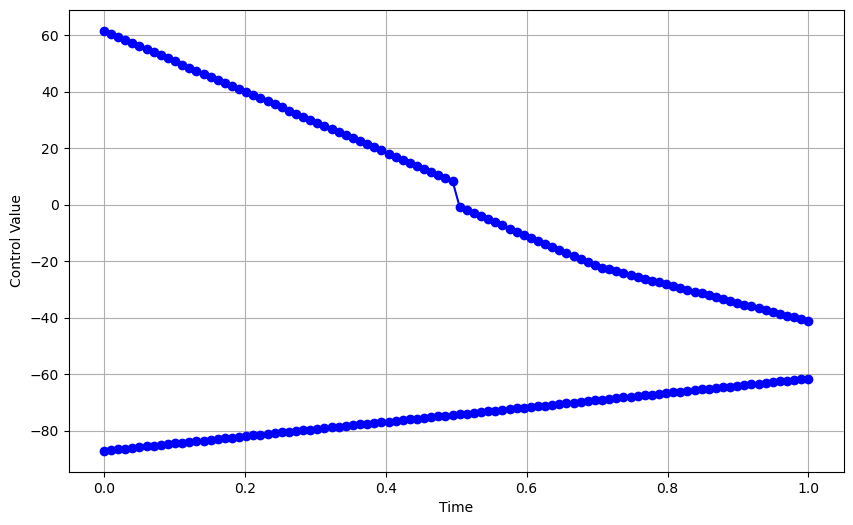

0 sigma:  [1. 0.] x0:  0.5 weight:  -17.755064899278317 type 0
1 sigma:  [1. 0.] x0:  0.7 weight:  108.61839339482896 type 1


In [ ]:
timepoints = np.linspace(0, params.T, int(params.T / params.dt))
array = np.array([u_k(t) for t in timepoints])
mpl.pyplot.figure(figsize=(10, 6))
mpl.pyplot.plot(timepoints, array, marker='o', linestyle='-', color='b')
mpl.pyplot.xlabel('Time')
mpl.pyplot.ylabel('Control Value')
mpl.pyplot.grid(True)
mpl.pyplot.show()

for idx, extremalPoint in enumerate(active_set):
    print(idx, 'sigma: ', extremalPoint.sigma, 'x0: ', extremalPoint.x_0, 'weight: ', weights[idx], 'type', extremalPoint.type)